# Path 1 – Training on Small Dataset

# 1. Introduction

This notebook presents the first modeling pipeline (Path 1) for spam detection using traditional machine learning methods trained on a small, labeled dataset. The primary goal is to build a baseline spam classifier using simple and interpretable models, evaluate them thoroughly, and assess their generalization capability on larger and more realistic datasets.

The entire process follows a modular structure, covering the following stages:

Data Loading & Exploration: Load a small benchmark dataset of SMS messages, and inspect its structure and balance.

Text Preprocessing: Clean and normalize text using lowercasing, punctuation removal, stopword filtering, and lemmatization.

Vectorization: Convert preprocessed text into numerical vectors using the TF-IDF method with limited dimensionality.

Model Training: Train two baseline classifiers — Naive Bayes and Support Vector Machine — on the vectorized small dataset.

Evaluation on Multiple Datasets:

Validation and test subsets from the small dataset.

A large noisy dataset (external).

A general, diverse dataset (realistic).

Prediction on Realistic Messages: Test both models on manually crafted spam and ham messages.

Result Summary & Comparison: Report and visualize the accuracy and F1 scores of both models, and identify the preferred one for deployment.

By the end of this notebook, we identify which model — among Naive Bayes and SVM — performs better in terms of precision, recall, and robustness, and whether a model trained on small clean data can generalize well to noisy or real-world inputs.

This notebook forms the foundation for comparison with more advanced approaches explored in subsequent paths (e.g., Path 2 with large training data).



# 2. Setup

## 2.1 Install & Import Required Libraries Load Libraries and Settings

In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 3. Load Datasets



## 3.1 Load Dataset 1 – Small Dataset (Path 1 Training)

This dataset contains 5,574 SMS messages labeled as **spam** or **ham**.  
It was used in the PyCon 2016 tutorial by *justmarkham* and is available on GitHub.  
**Role in project:** Used for training in Path 1.

In [2]:
# Load Dataset 1 (Small SMS Spam Dataset from GitHub)
url_small = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

# Load with appropriate parameters
df_small = pd.read_csv(
    url_small,
    sep="\t",
    header=None,
    names=["label", "message"]
)

# Preview the first few rows
df_small.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 3.2 Dataset 2 – Large Combined SMS Dataset (from Kaggle)

This dataset combines multiple SMS spam datasets and contains **about 10,000 messages**.  
It was created by *Tinu10kumar* and is available on Kaggle:  
[Kaggle Dataset Link](https://www.kaggle.com/datasets/tinu10kumar/sms-spam-dataset)  
**Role in project:** Used for evaluation (in Path 1) and training (in Path 2).


In [3]:
# Load Dataset 2 (Large Combined Dataset from Kaggle)
df_large = pd.read_csv("combined_dataset.csv")

df_large.head()

,target,text
0,spam,Congratulations! You've been selected for a lu...
1,spam,URGENT: Your account has been compromised. Cli...
2,spam,You've won a free iPhone! Claim your prize by ...
3,spam,Act now and receive a 50% discount on all purc...
4,spam,Important notice: Your subscription will expir...


## 3.3 Dataset 3 – External Evaluation Dataset (Mendeley Data)

This dataset contains **SMS spam/ham messages** collected independently for research purposes.  
It is publicly available from Mendeley Data:  
[Mendeley Dataset Link](https://data.mendeley.com/datasets/f45bkkt8pr/1)  
**Role in project:** Used as a generalization test set in both paths.


In [4]:
# Load Dataset 3 (External Evaluation Dataset)
df_general = pd.read_csv("Dataset_5971.csv")

df_general.head()


,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No


## 3.4 Dataset Overview and Basic Statistics

We explore the number of messages and spam/ham distribution in each dataset before cleaning.


### 3.4.1 Dataset 1 (Small)



In [5]:
print(df_small.shape)
print(df_small['label'].value_counts())

(5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


### 3.4.2 Dataset 2 (Large)
Note: The original label column in this dataset is called "target". We'll rename it in the cleaning phase.


In [6]:
print(df_large.shape)
print(df_large['target'].value_counts())


(10961, 2)
target
ham     8555
spam    2406
Name: count, dtype: int64


### 3.4.3 Dataset 3 (General)
Note: This dataset uses "LABEL" for labels and "TEXT" for message content. These will be standardized later.


In [7]:
print(df_general.shape)
print(df_general['LABEL'].value_counts())

(5971, 5)
LABEL
ham         4844
Smishing     616
spam         466
Spam          23
smishing      22
Name: count, dtype: int64


# 4. Data Cleaning & Harmonization

In this section, we clean and unify the structure of all three datasets to ensure compatibility across both training paths.

## 4.1 Standardize Column Names
We ensure that all datasets have consistent structure: two columns named `label` and `message`,
with all labels in lowercase and harmonized across datasets.


### 4.1.1 Dataset 1 – Small
Standard column names are already defined when loading the dataset, but we normalize label values for consistency.


In [8]:
# Dataset 1 already has correct column names from initial load:
# df_small.columns = ['label', 'message']

# Normalize label values just in case
df_small['label'] = df_small['label'].str.strip().str.lower()

# No changes needed
df_small.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 4.1.2 Dataset 2 – Large (from Kaggle)
We rename the original columns `target` → `label` and `text` → `message`.
We also lowercase the labels to ensure consistency.


In [9]:
# Rename columns to match standard names
df_large = df_large.rename(columns={'target': 'label', 'text': 'message'})

# Keep only relevant columns
df_large = df_large[['label', 'message']]

# Normalize label values
df_large['label'] = df_large['label'].str.strip().str.lower()


### 4.1.3 Dataset 3 – Generalization Test Set
We standardize the column names from `LABEL` and `TEXT` to `label` and `message`,
and unify label values such as `smishing` → `spam`.


In [10]:
# Rename and keep necessary columns
df_general = df_general[['LABEL', 'TEXT']]
df_general = df_general.rename(columns={'LABEL': 'label', 'TEXT': 'message'})
df_general['label'] = df_general['label'].str.strip().str.lower()
# Backup version with 'smishing' kept separately (optional)
df_general_with_smishing = df_general.copy()

# Convert all label types to unified 'spam'/'ham'
df_general['label'] = df_general['label'].replace({'smishing': 'spam'})


### 4.1.4 Check Types and Nulls
We verify that all datasets now have the correct types (`label`: string, `message`: string), and no missing values.


In [11]:
for name, df in zip(['Dataset 1', 'Dataset 2', 'Dataset 3'], [df_small, df_large, df_general]):
    print(f"--- {name} ---")
    print(df.dtypes)
    print("Null values:\n", df.isnull().sum())
    print("-" * 40)


--- Dataset 1 ---
label      object
message    object
dtype: object
Null values:
 label      0
message    0
dtype: int64
----------------------------------------
--- Dataset 2 ---
label      object
message    object
dtype: object
Null values:
 label      0
message    0
dtype: int64
----------------------------------------
--- Dataset 3 ---
label      object
message    object
dtype: object
Null values:
 label      0
message    0
dtype: int64
----------------------------------------


## 4.2 Remove Internal Duplicates
We identify and remove duplicate rows *within* each dataset individually before merging or cross-evaluation.


In [12]:
def check_and_remove_duplicates(df):
    """
    Checks for duplicate rows in the DataFrame.
    If found, prints counts before/after and removes them.
    Returns the cleaned DataFrame.
    """
    duplicate_count = df.duplicated().sum()

    if duplicate_count > 0:
        print(f"Number of duplicate rows: {duplicate_count}")
        print("\nMessage counts BEFORE removing duplicates:")
        print(df['label'].value_counts())
        print("Total rows BEFORE:", len(df))

        df = df.drop_duplicates()

        print("\nDuplicates removed.\n")
        print("Message counts AFTER removing duplicates:")
        print(df['label'].value_counts())
        print("Total rows AFTER:", len(df))

    else:
        print("No duplicates found.")
        print(df['label'].value_counts())
        print("Total rows:", len(df))

    return df


### 4.2.1 Apply to Dataset 1

In [13]:
print(">>> Dataset 1 (Small)")
df_small = check_and_remove_duplicates(df_small)

>>> Dataset 1 (Small)
Number of duplicate rows: 403

Message counts BEFORE removing duplicates:
label
ham     4825
spam     747
Name: count, dtype: int64
Total rows BEFORE: 5572

Duplicates removed.

Message counts AFTER removing duplicates:
label
ham     4516
spam     653
Name: count, dtype: int64
Total rows AFTER: 5169


### 4.2.2 Apply to Dataset 2

In [14]:
print("\n>>> Dataset 2 (Large)")
df_large = check_and_remove_duplicates(df_large)


>>> Dataset 2 (Large)
Number of duplicate rows: 674

Message counts BEFORE removing duplicates:
label
ham     8555
spam    2406
Name: count, dtype: int64
Total rows BEFORE: 10961

Duplicates removed.

Message counts AFTER removing duplicates:
label
ham     8014
spam    2273
Name: count, dtype: int64
Total rows AFTER: 10287


### 4.2.3 Apply to Dataset 3

In [15]:
print("\n>>> Dataset 3 (General Test)")
df_general = check_and_remove_duplicates(df_general)



>>> Dataset 3 (General Test)
Number of duplicate rows: 22

Message counts BEFORE removing duplicates:
label
ham     4844
spam    1127
Name: count, dtype: int64
Total rows BEFORE: 5971

Duplicates removed.

Message counts AFTER removing duplicates:
label
ham     4834
spam    1115
Name: count, dtype: int64
Total rows AFTER: 5949


## 4.3 Remove Overlapping Rows Between Datasets
To avoid data leakage and ensure fair evaluation, we remove overlapping rows between datasets
based on identical messages in the `message` column.


### 4.3.1 Remove rows from Dataset 2 that also exist in Dataset 1
We compare `message` columns and drop any duplicate messages from Dataset 2.
We will also check how the number of spam/ham messages has changed after removing duplicates.


In [16]:
# Before
counts_before_large = df_large['label'].value_counts()
print("Before removing overlaps with Dataset 1:")
print(f"Spam messages in Dataset 2: {counts_before_large.get('spam', 0)}")
print(f"Ham messages in Dataset 2: {counts_before_large.get('ham', 0)}")

# Remove overlapping rows from df_large
df_large_clean = df_large[~df_large['message'].isin(df_small['message'])].reset_index(drop=True)

# After removing
counts_after_large = df_large_clean['label'].value_counts()
print("\nAfter removing overlaps with Dataset 1:")
print(f"Spam messages in Dataset 2: {counts_after_large.get('spam', 0)}")
print(f"Ham messages in Dataset 2: {counts_after_large.get('ham', 0)}")

print(f"Total rows before removal: {len(df_large)}")
print(f"Total rows after removal: {len(df_large_clean)}")


Before removing overlaps with Dataset 1:
Spam messages in Dataset 2: 2273
Ham messages in Dataset 2: 8014

After removing overlaps with Dataset 1:
Spam messages in Dataset 2: 1848
Ham messages in Dataset 2: 3826
Total rows before removal: 10287
Total rows after removal: 5674


### 4.3.2 Remove rows from Dataset 3 that also exist in Dataset 1 or Dataset 2
After removing duplicates from Dataset 3, we'll check how the number of spam and ham messages have changed.


In [17]:
# Combine messages from Dataset 1 and cleaned Dataset 2
seen_messages = set(df_small['message']) | set(df_large_clean['message'])

# Remove overlapping messages from Dataset 3
df_general_clean = df_general[~df_general['message'].isin(seen_messages)].reset_index(drop=True)

print("After removing overlaps with Dataset 1 and 2:")
print(f"Original rows in Dataset 3: {len(df_general)}")
print(f"Remaining rows in Dataset 3: {len(df_general_clean)}")


After removing overlaps with Dataset 1 and 2:
Original rows in Dataset 3: 5949
Remaining rows in Dataset 3: 1148


# 5. Text Preprocessing

We clean and normalize the message texts to prepare them for vectorization.  
This includes:
- Lowercasing the text
- Replacing URLs and numbers with tokens (`URL_TOKEN`, `NUM_TOKEN`)
- Removing punctuation and extra spaces
- Lemmatization using NLTK
- Using a custom stopword list to **retain spam-indicative words** like `"won"`

Finally, we also convert the text labels (`ham` and `spam`) into **numerical labels** (`0` and `1`) required by machine learning models.


 ## 5.1 Setup

In [18]:
# Define standard stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define spam-indicative words to **keep**
important_words = {"won"}
custom_stop_words = stop_words - important_words  # Exclude important words from removal


## 5.2 Define the Preprocessing Function

In [19]:
def preprocess_text(text):
    """
    Preprocesses a single message:
    - Lowercases text
    - Replaces URLs with a token
    - Replaces numbers with a token
    - Removes punctuation
    - Lemmatizes each word
    - Removes stopwords (except custom important words)

    Returns cleaned text as a single string.
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "URL_TOKEN", text)
    text = re.sub(r"\d+", "NUM_TOKEN", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in custom_stop_words]
    return " ".join(words)


## 5.3 Apply Preprocessing to All Datasets

In [20]:
# Apply preprocessing to all datasets
df_small['clean_message'] = df_small['message'].apply(preprocess_text)
df_large_clean['clean_message'] = df_large_clean['message'].apply(preprocess_text)
df_general_clean['clean_message'] = df_general_clean['message'].apply(preprocess_text)


##5.4 Sample Output

In [21]:
# Show some examples
df_small[['message', 'clean_message']].head(5)

,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry NUMTOKEN wkly comp win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


## 5.5 Convert Labels to Numerical Format

To prepare the datasets for training, we convert the categorical labels ('ham', 'spam') into numerical values:  
- `ham` → `0`  
- `spam` → `1`  
This is necessary for most machine learning models that require numeric targets.


In [22]:
df_small['label_num'] = df_small['label'].map({'ham': 0, 'spam': 1})
df_large_clean['label_num'] = df_large_clean['label'].map({'ham': 0, 'spam': 1})
df_general_clean['label_num'] = df_general_clean['label'].map({'ham': 0, 'spam': 1})


# 6. Dataset Splitting

We split the cleaned and preprocessed dataset into training, validation, and test sets.  
This allows us to train models, tune hyperparameters, and evaluate generalization performance independently.

We use stratified sampling to ensure the **spam/ham distribution** remains consistent across splits:
- 70% training
- 15% validation
- 15% test


In [23]:
def split_data(X_text, y, test_size=0.3, val_ratio=0.5):
    """
    Splits the dataset into train/validation/test sets using stratified sampling.
    - test_size: portion of data held out for validation + test (e.g. 0.3)
    - val_ratio: ratio of validation to (validation + test) (e.g. 0.5 = 50/50 split)

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X_text, y, test_size=test_size, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


## Apply to Small Dataset

In [24]:
# Prepare inputs for splitting
X_small = df_small['clean_message']
y_small = df_small['label_num']

# Perform the split
X_text_train, X_text_val, X_text_test, y_train, y_val, y_test = split_data(X_small, y_small)

# Display sizes
print(f"Train size: {len(X_text_train)}")
print(f"Validation size: {len(X_text_val)}")
print(f"Test size: {len(X_text_test)}")


Train size: 3618
Validation size: 775
Test size: 776


In [25]:
print("Label distribution in train set:")
print(y_train.value_counts(normalize=True))

print("\nLabel distribution in validation set:")
print(y_val.value_counts(normalize=True))

print("\nLabel distribution in test set:")
print(y_test.value_counts(normalize=True))


Label distribution in train set:
label_num
0    0.873687
1    0.126313
Name: proportion, dtype: float64

Label distribution in validation set:
label_num
0    0.873548
1    0.126452
Name: proportion, dtype: float64

Label distribution in test set:
label_num
0    0.873711
1    0.126289
Name: proportion, dtype: float64


# 7. Vectorization Setup

We convert preprocessed text data into numerical features using **TF-IDF vectorization**.  
This transforms each message into a vector of word importance scores.

We use the following parameters:
- `max_features=3000`: to reduce dimensionality and avoid overfitting.

We fit the vectorizer **only on the training set** to avoid data leakage.

## 7.1 Vectorizer Definition

In [26]:
vectorizer = TfidfVectorizer(
    max_features=3000,  # Limit dimensionality
)

## 7.2 Apply TF-IDF Vectorizer

We transform each dataset into TF-IDF vectors using the `vectorizer` defined above.


### 7.2.1 Dataset 1 (small – split into train/val/test)

In [27]:
X_train = vectorizer.fit_transform(X_text_train)
X_val = vectorizer.transform(X_text_val)
X_test = vectorizer.transform(X_text_test)

In [28]:
print("Shape of TF-IDF vectors (train):", X_train.shape)

Shape of TF-IDF vectors (train): (3618, 3000)


### 7.2.2 Dataset 2 (large – only transform)

In [29]:
X_large = vectorizer.transform(df_large_clean['clean_message'])
y_large= df_large_clean['label_num']

### 7.2.3 Dataset 3 (general – only transform)

In [30]:
# Save for future evaluation in path 3
joblib.dump(df_general_clean, "df_general_clean.pkl")

['df_general_clean.pkl']

In [31]:
X_general = vectorizer.transform(df_general_clean['clean_message'])
y_general= df_general_clean['label_num']

## optionally

In [32]:
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Large dataset shape: {X_large.shape}")
print(f"General dataset shape: {X_general.shape}")


Train set shape: (3618, 3000)
Validation set shape: (775, 3000)
Test set shape: (776, 3000)
Large dataset shape: (5674, 3000)
General dataset shape: (1148, 3000)


# 8. Model Training and Evaluation
We train and evaluate two classification models — Naive Bayes and Linear Support Vector Machine — using the small dataset.
Evaluation is performed first on the validation set and then on the final test set. We report standard metrics such as accuracy, F1-score, and confusion matrix.


## 8.1 Define and Train Models

In [33]:
# Define models
models = {
    "NB-1": MultinomialNB(),   # Naive Bayes model
    "SVM-1": LinearSVC()       # Linear Support Vector Machine model
}

# Store trained models
trained_models = {}

print(" Evaluating Models on Validation Set")
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Train the model on the small training dataset
    model.fit(X_train, y_train)

    # Save the trained model
    trained_models[name] = model

    # Predict on the small validation set
    y_val_pred = model.predict(X_val)

    # Calculate evaluation metrics
    acc_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    cm_val = confusion_matrix(y_val, y_val_pred)

    # Display evaluation results
    print(f"Validation Accuracy: {acc_val:.4f}")
    print(f"Validation F1 Score: {f1_val:.4f}")
    print("Validation Confusion Matrix:\n", cm_val)
    print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

 Evaluating Models on Validation Set

=== NB-1 ===
Validation Accuracy: 0.9652
Validation F1 Score: 0.8402
Validation Confusion Matrix:
 [[677   0]
 [ 27  71]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       677
           1       1.00      0.72      0.84        98

    accuracy                           0.97       775
   macro avg       0.98      0.86      0.91       775
weighted avg       0.97      0.97      0.96       775


=== SVM-1 ===
Validation Accuracy: 0.9768
Validation F1 Score: 0.9032
Validation Confusion Matrix:
 [[673   4]
 [ 14  84]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       677
           1       0.95      0.86      0.90        98

    accuracy                           0.98       775
   macro avg       0.97      0.93      0.95       775
weighted avg       0.98      0.98      0.98    

## 8.2 Final Evaluation on Test Set
After selecting models based on validation performance, we report final evaluation metrics on the unseen test set.


In [34]:
for name, model in trained_models.items():
    print(f"\n=== {name} (Final Test Evaluation) ===")
    y_test_pred = model.predict(X_test)

    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f"Test Accuracy: {acc_test:.4f}")
    print(f"Test F1 Score: {f1_test:.4f}")
    print("Confusion Matrix:\n", cm_test)
    print("Classification Report:\n", classification_report(y_test, y_test_pred))



=== NB-1 (Final Test Evaluation) ===
Test Accuracy: 0.9781
Test F1 Score: 0.9050
Confusion Matrix:
 [[678   0]
 [ 17  81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       678
           1       1.00      0.83      0.91        98

    accuracy                           0.98       776
   macro avg       0.99      0.91      0.95       776
weighted avg       0.98      0.98      0.98       776


=== SVM-1 (Final Test Evaluation) ===
Test Accuracy: 0.9897
Test F1 Score: 0.9579
Confusion Matrix:
 [[677   1]
 [  7  91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       678
           1       0.99      0.93      0.96        98

    accuracy                           0.99       776
   macro avg       0.99      0.96      0.98       776
weighted avg       0.99      0.99      0.99       776



# 9. Evaluation on External Datasets

To assess the generalization ability of our trained models, we evaluate them on two external datasets:
- **Dataset 2:** Cleaned version of the larger dataset.
- **Dataset 3:** Manually created general dataset.


## 9.1 Evaluate on Clean Large Dataset

In [35]:
print("\n Evaluating Pretrained Models on 2nd Dataset (Clean Large Dataset)")

for name, model in trained_models.items():
    print(f"\n=== {name} on 2nd Dataset ===")
    y_large_pred = model.predict(X_large)

    acc_2nd = accuracy_score(y_large, y_large_pred)
    f1_2nd = f1_score(y_large, y_large_pred)
    cm_2nd = confusion_matrix(y_large, y_large_pred)

    print(f"Accuracy: {acc_2nd:.4f}")
    print(f"F1 Score: {f1_2nd:.4f}")
    print("Confusion Matrix:\n", cm_2nd)
    print("Classification Report:\n", classification_report(y_large, y_large_pred))



 Evaluating Pretrained Models on 2nd Dataset (Clean Large Dataset)

=== NB-1 on 2nd Dataset ===
Accuracy: 0.7224
F1 Score: 0.3368
Confusion Matrix:
 [[3699  127]
 [1448  400]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.97      0.82      3826
           1       0.76      0.22      0.34      1848

    accuracy                           0.72      5674
   macro avg       0.74      0.59      0.58      5674
weighted avg       0.73      0.72      0.67      5674


=== SVM-1 on 2nd Dataset ===
Accuracy: 0.4605
F1 Score: 0.3407
Confusion Matrix:
 [[1822 2004]
 [1057  791]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.48      0.54      3826
           1       0.28      0.43      0.34      1848

    accuracy                           0.46      5674
   macro avg       0.46      0.45      0.44      5674
weighted avg       0.52      0.46      0.48      5674



## 9.2 Evaluate on General Dataset

In [36]:
print("\n Evaluating Pretrained Models on 3rd Dataset (General Dataset)")

for name, model in trained_models.items():
    print(f"\n=== {name} on 3rd Dataset ===")
    y_pred = model.predict(X_general)

    acc_gen = accuracy_score(y_general, y_pred)
    f1_gen = f1_score(y_general, y_pred)
    cm_gen = confusion_matrix(y_general, y_pred)

    print(f"Accuracy: {acc_gen:.4f}")
    print(f"F1 Score: {f1_gen:.4f}")
    print("Confusion Matrix:\n", cm_gen)
    print("Classification Report:\n", classification_report(y_general, y_pred))



 Evaluating Pretrained Models on 3rd Dataset (General Dataset)

=== NB-1 on 3rd Dataset ===
Accuracy: 0.8711
F1 Score: 0.8474
Confusion Matrix:
 [[589   0]
 [148 411]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       589
           1       1.00      0.74      0.85       559

    accuracy                           0.87      1148
   macro avg       0.90      0.87      0.87      1148
weighted avg       0.90      0.87      0.87      1148


=== SVM-1 on 3rd Dataset ===
Accuracy: 0.9007
F1 Score: 0.8878
Confusion Matrix:
 [[583   6]
 [108 451]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       589
           1       0.99      0.81      0.89       559

    accuracy                           0.90      1148
   macro avg       0.92      0.90      0.90      1148
weighted avg       0.91      0.90      0.90      1148



### 9.3 Save Trained Models and Vectorizer

To facilitate future use — such as batch predictions, deployment in production, or further experimentation — we save the trained models and the TF-IDF vectorizer using `joblib`. This ensures consistency between the training pipeline and downstream inference.


In [37]:

# Save Naive Bayes model
joblib.dump(trained_models["NB-1"], "nb1_model.pkl")

# Save SVM model
joblib.dump(trained_models["SVM-1"], "svm1_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer_path1.pkl")

print(" Models and vectorizer saved successfully.")


 Models and vectorizer saved successfully.


# 10. Predicting New Messages

We now test the trained models on unseen, realistic messages to simulate a real-world spam filtering scenario. First, we load the saved models and vectorizer, then classify new messages using the same preprocessing and vectorization steps as during training.


In [38]:
# 10.1 Load Saved Models and Vectorizer for Prediction

# Load saved models
trained_models = {
    "NB-1": joblib.load("nb1_model.pkl"),
    "SVM-1": joblib.load("svm1_model.pkl")
}

# Load the saved TF-IDF vectorizer
vectorizer = joblib.load("tfidf_vectorizer_path1.pkl")

# Define classification function
def classify_message(msg, model=trained_models["NB-1"]):
    cleaned = preprocess_text(msg)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    return "Spam" if prediction else "Legitimate"


In [39]:
# 10.2 Real-World Test Messages
test_messages = [
    # Likely Spam
    "URGENT! Your account has been locked. Verify your identity at http://fakebanklogin.com now.",
    "Win a brand new iPhone 15! Just reply YES to enter the contest.",
    "You have received a cash reward of $2000. Claim here: rewardz.co/claim",
    "Congratulations! You've been selected for a free cruise to the Bahamas.",

    # Likely Ham (legitimate)
    "Don’t forget your doctor’s appointment tomorrow at 10am.",
    "Are we still on for dinner this Friday night?",
    "Here's the PDF for the meeting agenda. Let me know if you have any questions.",
    "Thanks for your payment. Your subscription has been renewed."
]

# 11.3 Classify Each Message Using All Models
for msg in test_messages:
    print(f"\n🔍 Test Message: {msg}")
    for name, model in trained_models.items():
        label = classify_message(msg, model=model)
        print(f"{name} Prediction: {label}")



🔍 Test Message: URGENT! Your account has been locked. Verify your identity at http://fakebanklogin.com now.
NB-1 Prediction: Spam
SVM-1 Prediction: Spam

🔍 Test Message: Win a brand new iPhone 15! Just reply YES to enter the contest.
NB-1 Prediction: Spam
SVM-1 Prediction: Spam

🔍 Test Message: You have received a cash reward of $2000. Claim here: rewardz.co/claim
NB-1 Prediction: Spam
SVM-1 Prediction: Spam

🔍 Test Message: Congratulations! You've been selected for a free cruise to the Bahamas.
NB-1 Prediction: Spam
SVM-1 Prediction: Spam

🔍 Test Message: Don’t forget your doctor’s appointment tomorrow at 10am.
NB-1 Prediction: Legitimate
SVM-1 Prediction: Legitimate

🔍 Test Message: Are we still on for dinner this Friday night?
NB-1 Prediction: Legitimate
SVM-1 Prediction: Legitimate

🔍 Test Message: Here's the PDF for the meeting agenda. Let me know if you have any questions.
NB-1 Prediction: Legitimate
SVM-1 Prediction: Legitimate

🔍 Test Message: Thanks for your payment. Your sub

# 11. Result Summary

In this section, we summarize and compare the performance of the two models — Naive Bayes (NB-1) and Support Vector Machine (SVM-1) — across four evaluation datasets. We report both accuracy and F1 score metrics, and visualize the results to support interpretation.


## 11.1 Comparison of Model Performance

In [40]:
# Collect model performance results
results = {
    "Dataset": ["Validation Set", "Test Set", "Large Dataset", "General Dataset"],
    "NB-1 Accuracy": [],
    "SVM-1 Accuracy": [],
    "NB-1 F1": [],
    "SVM-1 F1": []
}

# Evaluate and append results
def evaluate_and_append(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred), f1_score(y, y_pred)

# Loop over datasets
datasets_eval = [
    ("Validation Set", X_val, y_val),
    ("Test Set", X_test, y_test),
    ("Large Dataset", X_large, y_large),
    ("General Dataset", X_general, y_general)
]

for label, X_eval, y_eval in datasets_eval:
    nb_acc, nb_f1 = evaluate_and_append(trained_models["NB-1"], X_eval, y_eval)
    svm_acc, svm_f1 = evaluate_and_append(trained_models["SVM-1"], X_eval, y_eval)

    results["NB-1 Accuracy"].append(nb_acc)
    results["SVM-1 Accuracy"].append(svm_acc)
    results["NB-1 F1"].append(nb_f1)
    results["SVM-1 F1"].append(svm_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df)


,Dataset,NB-1 Accuracy,SVM-1 Accuracy,NB-1 F1,SVM-1 F1
0,Validation Set,0.965161,0.976774,0.840237,0.903226
1,Test Set,0.978093,0.989691,0.905028,0.957895
2,Large Dataset,0.722418,0.460522,0.336842,0.340728
3,General Dataset,0.871080,0.900697,0.847423,0.887795


In [41]:
# Save results to CSV for later combination
results_df.to_csv("results_path1.csv", index=False)

## 11.2 Visualization of Performance Comparison

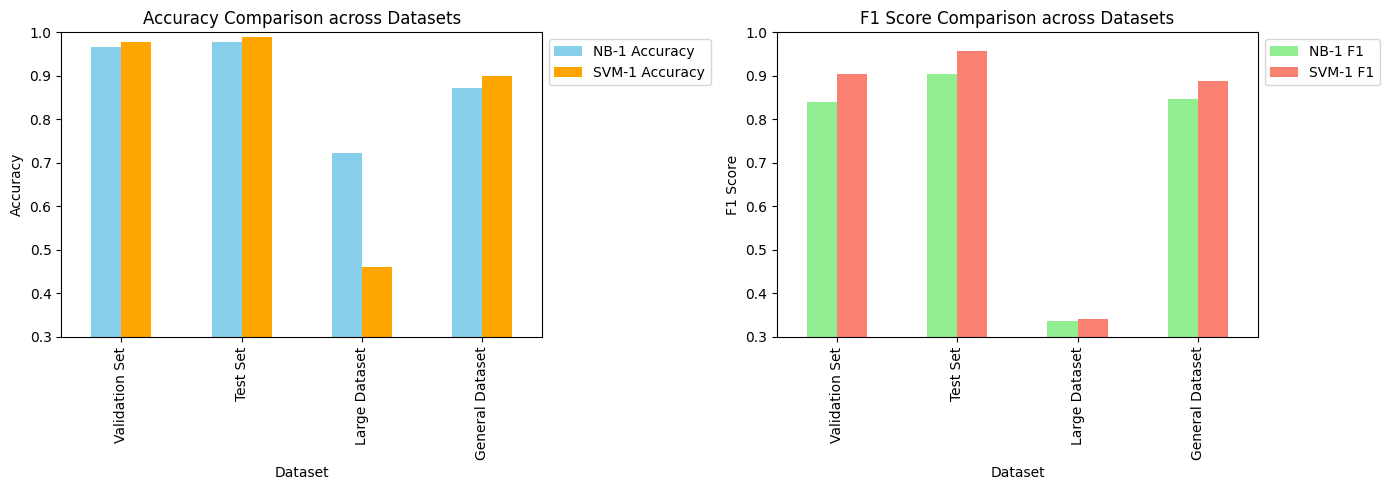

In [42]:
# 12.2 Visualization of Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
results_df.plot(x="Dataset", y=["NB-1 Accuracy", "SVM-1 Accuracy"], kind="bar", ax=axes[0],
                color=["skyblue", "orange"], legend=False)
axes[0].set_title("Accuracy Comparison across Datasets")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.3, 1.0)
axes[0].legend(["NB-1 Accuracy", "SVM-1 Accuracy"], loc='upper left', bbox_to_anchor=(1.0, 1.0))

# F1 score plot
results_df.plot(x="Dataset", y=["NB-1 F1", "SVM-1 F1"], kind="bar", ax=axes[1],
                color=["lightgreen", "salmon"], legend=False)
axes[1].set_title("F1 Score Comparison across Datasets")
axes[1].set_ylabel("F1 Score")
axes[1].set_ylim(0.3, 1.0)
axes[1].legend(["NB-1 F1", "SVM-1 F1"], loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()


# 12. Which Model Performed Better in Path 1?

In Path 1, both models—NB-1 and SVM-1—were trained on a smaller dataset. Across the validation and final test sets, SVM-1 consistently outperformed NB-1, particularly in detecting spam messages.

On the validation set, SVM-1 achieved a higher F1 score (0.9032 vs. 0.8402), demonstrating stronger balance between precision and recall. This performance gap widened on the final test set, where SVM-1 reached an F1 score of 0.9579, significantly surpassing NB-1’s 0.9050. SVM-1 also maintained better spam recall and lower false negatives.

However, when tested on the large clean external dataset (Dataset 2), both models underperformed—especially SVM-1, which dropped to an accuracy of 46.05% and an F1 score of 0.3407. NB-1 performed slightly better with 72.24% accuracy and a similar F1 score of 0.3368, showing that both models struggled to generalize from small-scale training.

On the general third dataset (Dataset 3), SVM-1 again outperformed NB-1 with an F1 score of 0.8878 compared to 0.8474, indicating stronger robustness and spam detection accuracy in more realistic conditions.

In summary, **SVM-1** performed better than NB-1 on both internal evaluations and external datasets, with higher F1 scores and better spam classification. Yet, both models showed limitations when evaluated on a much larger and more complex dataset, underscoring the constraints of training on limited data in Path 1.

---

## Additional Note:

In Section **10. Predicting New Messages**, both models correctly classified real-world spam and ham messages, confirming their practical applicability and robustness in production environments.
